In [1]:
import cv2  # 仅作为读取使用
import numpy as np

In [2]:
def mean_filter(image, K_size):
    H, W, C = image.shape
    ## 图片零填充
    pad = K_size // 2
    out = np.zeros((H + pad * 2, W + pad * 2, C), dtype=np.float32)
    out[pad: pad + H, pad: pad + W] = image.copy().astype(np.float32)

    for y in range(H):
        for x in range(W):
            for c in range(C):
                # 计算均值
                sum = 0
                count = 0
                for dy in range(-pad, pad + 1):   # 镜像反射
                    for dx in range(-pad, pad + 1): 
                        ny, nx = y + dy, x + dx
                        # 检查边界
                        if 0 <= ny < H and 0 <= nx < W:
                            sum += image[ny, nx, c]
                            count += 1

                # 设置输出图像的当前像素点
                out[y, x, c] = sum // count
    out = np.where(out < 0, 0, np.where(out > 255, 255, out))
    out = out[pad: pad + H, pad: pad + W].astype(np.uint8)
    return out

In [4]:
# 读取图片
img = cv2.imread('cat.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # 转换颜色通道

# 使用自定义的均值滤波器
output = mean_filter(img, 3)

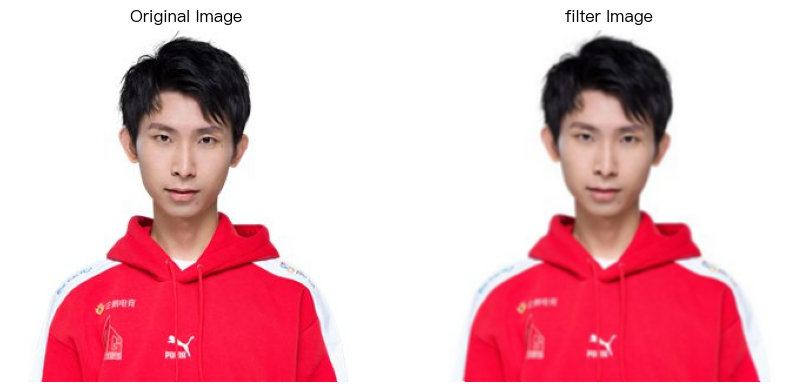

In [5]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(img)
ax1.set_title('Original Image')
ax1.axis('off')  # 关闭坐标轴

ax2.imshow(output)
ax2.set_title('filter Image')
ax2.axis('off')  # 关闭坐标轴

plt.show()

In [6]:
# Gaussian filter 
def gaussian_filter(img, K_size=3, sigma=1.3):
    H, W, C = img.shape
    ## 图片零填充
    pad = K_size // 2
    out = np.zeros((H + pad * 2, W + pad * 2, C), dtype=np.float32)
    out[pad: pad + H, pad: pad + W] = img.copy().astype(np.float32)
 
    ## 构造高斯卷积核
    K = np.zeros((K_size, K_size), dtype=np.float32)
    for x in range(-pad, -pad + K_size):
        for y in range(-pad, -pad + K_size):
            K[y + pad, x + pad] = np.exp( -(x ** 2 + y ** 2) / (2 * (sigma ** 2)))
 
    K /= (2 * np.pi * sigma * sigma)    
    K /= K.sum()    # 归一化
    tmp = out.copy()
 
    # filtering
    for y in range(H):
        for x in range(W):
            for c in range(C):
                out[pad + y, pad + x, c] = np.sum(K * tmp[y: y + K_size, x: x + K_size, c])
 
    out = np.where(out < 0, 0, np.where(out > 255, 255, out))
    out = out[pad: pad + H, pad: pad + W].astype(np.uint8)
    return out

In [7]:
# 读取图片
img = cv2.imread('dog.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # 转换颜色通道

output = gaussian_filter(img, K_size=3, sigma=1.3)

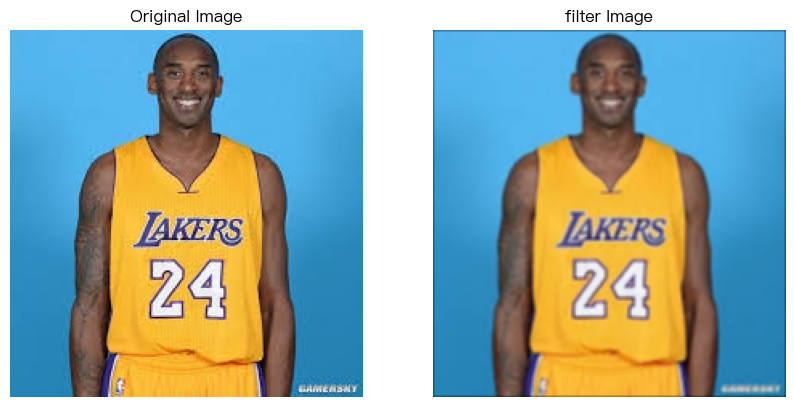

In [8]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(img)
ax1.set_title('Original Image')
ax1.axis('off')  # 关闭坐标轴

ax2.imshow(output)
ax2.set_title('filter Image')
ax2.axis('off')  # 关闭坐标轴

plt.show()

二维数字图像的滤波主要分为 空间域滤波 和 频域滤波：

空间域滤波：用各种模板直接与图像进行卷积运算，实现对图像的处理，这种方法直接对图像空间操作，操作简单


频域滤波：在实现某些图像处理的时候，频域的处理比空间域更简单；对于在空间域上的数字图像，根据卷积定理可以通过**傅立叶变换**将空域卷积滤波变换为频域滤波，然后再将频域滤波处理后的图像 **反变换**回空间域

1）什么是低频？
低频就是颜色缓慢地变化,也就是灰度缓慢地变化,就代表着那是连续渐变的一块区域,这部分就是低频. 对于一幅图像来说，除去高频的就是低频了，也就是边缘以内的内容为低频，而边缘内的内容就是图像的大部分信息，即图像的大致概貌和轮廓，是图像的近似信息。


2）什么是高频?
反过来, 高频就是频率变化快.图像中什么时候灰度变化快？就是相邻区域之间灰度相差很大,这就是变化得快。图像中,一个影像与背景的边缘部位,通常会有明显的差别,也就是说变化那条边线那里,灰度变化很快,也即是变化频率高的部位。因此，图像边缘的灰度值变化快，就对应着频率高，即高频显示图像边缘。图像的细节处也是属于灰度值急剧变化的区域，正是因为灰度值的急剧变化，才会出现细节。

另外噪声（即噪点）也是这样,在一个像素所在的位置,之所以是噪点,就是因为它与正常的点颜色不一样了，也就是说该像素点灰度值明显不一样了,也就是灰度有快速地变化了,所以是高频部分，因此有噪声在高频这么一说。

为了便于观察，常常采取 换位 方法使直流成分出现在窗口的中央（中心化），变换后中心为低频，向外是高频。

在频域，可以很方便的实现 图像的锐化和模糊：
截取频率的低频分量，对其作傅立叶反变换，得到的就是模糊后的图像，即 低通滤波
截取频率的高频分量，对其作傅立叶反变换，得到的就是锐化后的图像，即 高通滤波

高低通滤波

1. Imread函数读取图像
2. 将RGB图像拆分为R、G、B三张单色图
3. 调用fft2函数对R、G、B单色图分别进行进行DFT处理
4. 调用abs函数取得频谱采用log处理，进行灰度压缩
5. 调用fftshift函数中心化处理（打印图片）
6. 利用理想低通滤波器low filter对图像频谱进行滤波，滤除高频成分（打印图片）
7. 调用ifftshift函数去中心化处理（打印图片）
8. 对输出结果fft2反变化得到滤波后的R、G、B图像
9. 将分别处理后的R、G、B图像合成为一幅图像，然后进行显示，得到频域滤波后的RGB图像（打印图片）

高通滤波器是指通过高频的滤波器，衰减低频而通过高频，常用于增强尖锐的细节，但会导致图像的对比度会降低。该滤波器将检测图像的某个区域，根据像素与周围像素的差值来提升像素的亮度。图展示了频谱图像，其中心区域为低频部分。

低通滤波器是指通过低频的滤波器，衰减高频而通过低频，常用于模糊图像。低通滤波器与高通滤波器相反，当一个像素与周围像素的插值小于一个特定值时，平滑该像素的亮度，常用于去燥和模糊化处理。如PS软件中的高斯模糊，就是常见的模糊滤波器之一，属于削弱高频信号的低通滤波器。